# Coffee Quality Model Building

Those are the results obtained in the study

In [1]:
import pandas as pd
import numpy as np
from unicodedata import normalize
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats
import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def remove_acento(y) :
    return normalize('NFKD', y).encode('ASCII','ignore').decode('ASCII').lower()

In [3]:
df = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="BatchField Data")
df = df.astype(str)
df = df.applymap(remove_acento)
pivot_df = pd.pivot_table(df, columns = "BatchFieldID", index ="BatchID", values = "Value", aggfunc=lambda x: '-'.join(x))
pivot_df.index = pivot_df.index.astype(int)
df_target = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="Batchs")
df_target = df_target.rename({'Batchid': 'BatchID'}, axis=1)  # new method
df_target.set_index('BatchID', inplace=True)
df_target.index = df_target.index.astype(int)

In [4]:
descrip = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="Batch Field Descrip")
descrip.set_index('BatchFieldID', inplace=True)
#descrip.sort_values(by = 'BatchFieldID')
#descrip

In [5]:
fdf = pd.merge(pivot_df, df_target, left_index=True, right_index=True)
fdf['CreationDate'] = pd.to_datetime(fdf['CreationDate'], format='%Y-%b-%d')
fdf['doy'] = fdf['CreationDate'].apply(lambda row: row.timetuple().tm_yday)
list_top_4=fdf.Process.value_counts().sort_values(ascending=False).head(5).index
# for category in fdf['Variety'].unique():
#     fdf[category]=np.where(fdf['Variety']==category,1,0)
for category in fdf['Process'].unique():
    fdf[category]=np.where(fdf['Process']==category,1,0)
#fdf['NATURAL']=np.where(fdf['Process']=='NATURAL',1,0)

In [83]:
list_top_4

Index(['NATURAL', 'LACTICO', 'BIO-INNOVATION W ', 'Dynamic Cherry',
       'Intrinsic Cherry'],
      dtype='object')

Explaining a bit about some new variables created. In first place, a "day of the year" column is created, based on the date of creation.

Second, the four top varieties ('Castillo', 'Geisha', 'Mixed', 'Sidra') are converted into columns, and if the batch is composed by one of this variales, it gets value 1 in the respective column, otherwise it gets 0.

The same is done to the Process method, being wheter 1 if 'NATURAL' or 0 if not.

In [95]:
dt = [18,
19,
20,
21,
30,
31,
36,
37,
43,
44,
51,
52,
58, "Sca"]

dt = [str(x) for x in dt]

txt = [4,
10,
32,
35,
45,
50,
59,
61,
62,
63,
69,
70,
71,"Process","Program BatchCode", "Proces", "Variety", "Sca"]

txt = [str(x) for x in txt]

num = [1,
2,
3,
5,
6,
7,
8,
9,
22,
25,
26,
28,
29,
38,
39,
40,
41,
42,
56,
57,
60,
64,
65,
66,
67,
68, "YieldFactor","NetWeight", "Sca",'NATURAL', 'LACTICO', 'BIO-INNOVATION W ', 'Dynamic Cherry',
       'Intrinsic Cherry', 'doy']

num = [str(x) for x in num]
dt_df = fdf[fdf.columns.intersection(dt)]
tx_df = fdf[fdf.columns.intersection(txt)]
nm_df = fdf[fdf.columns.intersection(num)].apply(pd.to_numeric)

Now the variables suggested by you are added to the dataset

In [96]:
dt_df["51"] = pd.to_datetime(dt_df["51"], utc = True)
dt_df["52"] = pd.to_datetime(dt_df["52"], utc =True)

In [97]:
#dt_df.dtypes
dt_df.iloc[:, :-1] = dt_df.iloc[:, :-1].apply(pd.to_datetime, errors='coerce')
dt_df["delta_secado_mecanico"] = dt_df["52"] - dt_df["51"]
dt_df["delta_secado_natural"] = dt_df["44"] - dt_df["43"]
dt_df["delta_f_cb"] = dt_df["31"] - dt_df["30"]
dt_df["delta_f_cc"] = dt_df["19"] - dt_df["18"]
dt_df["delta_f_cc"] =  dt_df["delta_f_cc"] / np.timedelta64(1, 'h')
dt_df["delta_f_cb"] =  dt_df["delta_f_cb"] / np.timedelta64(1, 'h')
dt_df['delta_secado_natural'] =  dt_df['delta_secado_natural'] / np.timedelta64(1, 'h')
dt_df['delta_secado_mecanico'] =  dt_df['delta_secado_mecanico'] / np.timedelta64(1, 'h')

# nm_df["delta_t1"] = nm_df["3"] - nm_df["26"]
# nm_df["delta_t2"] = nm_df["26"] - nm_df["40"]

nm_df["delta_ph1"] = nm_df["2"] - nm_df["25"]
nm_df["delta_ph2"] = nm_df["39"] - nm_df["25"]

nm_df["delta_brix1"] = nm_df["1"] - nm_df["22"]
nm_df["delta_brix2"] = nm_df["38"] - nm_df["22"]

# nm_df["delta_u_natural"] = nm_df["60"] - nm_df["65"]
# nm_df["delta_u_mecanico"] = nm_df["60"] - nm_df["66"]

In [98]:
parcial_dt_df = dt_df[["delta_secado_mecanico","delta_secado_natural","delta_f_cc","delta_f_cb"]]
nm_df = pd.merge(nm_df, parcial_dt_df, left_index=True, right_index=True)

In [100]:
nm_df.columns

Index(['1', '2', '22', '25', '26', '28', '29', '3', '38', '39', '40', '41',
       '42', '5', '56', '57', '6', '60', '64', '65', '66', '67', '68', '7',
       '8', '9', 'YieldFactor', 'Sca', 'NetWeight', 'doy', 'NATURAL',
       'LACTICO', 'Intrinsic Cherry', 'Dynamic Cherry', 'BIO-INNOVATION W ',
       'delta_ph1', 'delta_ph2', 'delta_brix1', 'delta_brix2',
       'delta_secado_mecanico', 'delta_secado_natural', 'delta_f_cc',
       'delta_f_cb'],
      dtype='object')

In [101]:
nm_df.columns = ['brix1', 'ph1', 'despulpado_brix', 'despulpado_ph', 'despulpado_t', 'despulpado_partidos',\
                 'despulpado_broca', 'temperatura', 'cl_brix', 'cl_ph', 'cl_t', 'cl_partidos',
       'cl_broca', 'cereza_sana', 'n_bultos', 'kg_amuestra', 'pintones_maduros', 'humedad', 't_masa',\
                 'humedad_final_natural', 'humedad_final_mecanico', 'rechazo_por_flote', 'rechazo_cafe_seco', 'defectos',
       'granos_vanos', 'sobremaduros', 'YieldFactor', 'Sca', 'NetWeight', 'doy', 'NATURAL',\
       'LACTICO', 'Intrinsic Cherry', 'Dynamic Cherry', 'BIO-INNOVATION W ',\
       'delta_ph1', 'delta_ph2', 'delta_brix1', 'delta_brix2',\
       'delta_secado_mecanico', 'delta_secado_natural', 'delta_f_cc',\
       'delta_f_cb']

In [102]:
nm_df.drop(['n_bultos', 'kg_amuestra'], axis = 1, inplace = True)

In [104]:
nm_df = nm_df[nm_df.Sca != 0]
#dataset.drop(['rechazo_por_flote', 'rechazo_cafe_seco'], axis=1, inplace=True)
#dataset = dataset.dropna()
perc =50.0 # Here N is 75
min_count =  int(((100-perc)/100)*nm_df.shape[1] + 1)
dataset = nm_df.dropna( axis=0, 
                    thresh=min_count)
df_sliced = nm_df.dropna(axis=1, thresh=int(0.5*len(nm_df)))
# perc =50.0 # Here N is 75
# min_count =  int(((100-perc)/100)*df_sliced.shape[1] + 1)
# dataset_sliced = df_sliced.dropna( axis=0, 
#                     thresh=min_count)

Here, all the columns that has less than 50% of valid values are excluded. Those are the remaining columns

In [105]:
df_sliced.columns.values

array(['brix1', 'ph1', 'temperatura', 'cereza_sana', 'pintones_maduros',
       'humedad', 't_masa', 'humedad_final_natural', 'defectos',
       'granos_vanos', 'sobremaduros', 'YieldFactor', 'Sca', 'NetWeight',
       'doy', 'NATURAL', 'LACTICO', 'Intrinsic Cherry', 'Dynamic Cherry',
       'BIO-INNOVATION W ', 'delta_secado_natural', 'delta_f_cc'],
      dtype=object)

Those are the excluded ones

In [106]:
res = [i for i in nm_df.columns if i not in df_sliced.columns]
res

['despulpado_brix',
 'despulpado_ph',
 'despulpado_t',
 'despulpado_partidos',
 'despulpado_broca',
 'cl_brix',
 'cl_ph',
 'cl_t',
 'cl_partidos',
 'cl_broca',
 'humedad_final_mecanico',
 'rechazo_por_flote',
 'rechazo_cafe_seco',
 'delta_ph1',
 'delta_ph2',
 'delta_brix1',
 'delta_brix2',
 'delta_secado_mecanico',
 'delta_f_cb']

In [107]:
def get_num_outliers (column):
    q1 = nm_df[column].quantile(0.25)
    q3 = nm_df[column].quantile(0.75)
    return 1 - (sum((nm_df[column]<q1) | (nm_df[column]>q3))/nm_df[column].count())

def get_nan(column):
    c_nan = nm_df[column].isna().sum()
    c_nan = c_nan / len(fdf)
    return 1-c_nan

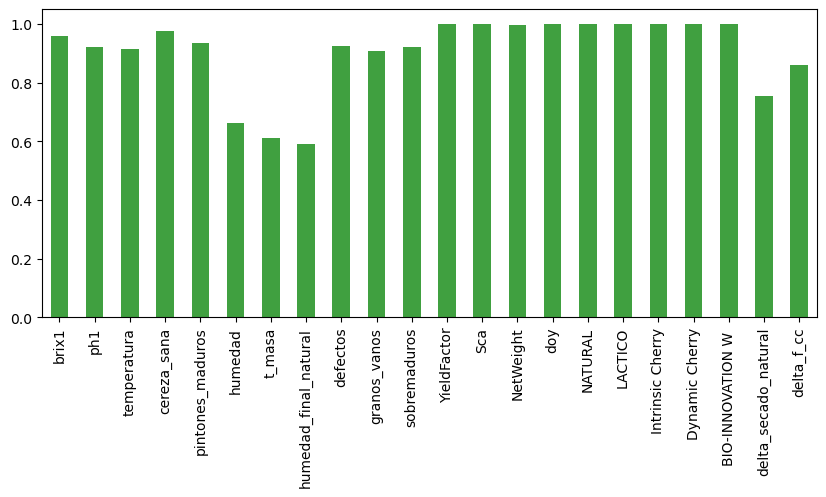

In [122]:
col = df_sliced.columns.to_frame().reset_index().drop(0, axis =1)
col["outliers"] = col.apply(lambda row : get_num_outliers(row["index"]), axis =1)
col["nan"] = col.apply(lambda row: get_nan(row["index"]), axis =1)
col["confidence"] = col["outliers"]*col["nan"]
col.set_index('index', inplace=True)
#col.index = col.index.astype(int)
descrip.index = descrip.index.map(str)
nan_count = pd.merge(descrip, col, left_index=True, right_index=True, how = "right")
#nan_count = nan_count.rename({0: 'nan_percentage'}, axis=1)  # new method
nan_count.sort_values(by = 'confidence')
nan_count.plot(kind ="bar",use_index = True, y='nan', rot=0, figsize=(10,4), alpha = 0.75, color = "green")
plt.xticks(rotation=90)
plt.legend('',frameon=False)
plt.xlabel("")
plt.show()
#nan_count.sort_values(by = 'confidence')

Again, its impossible to see any clear correlation or sazonal beahvior

<AxesSubplot:title={'center':'Correlation with Sca'}>

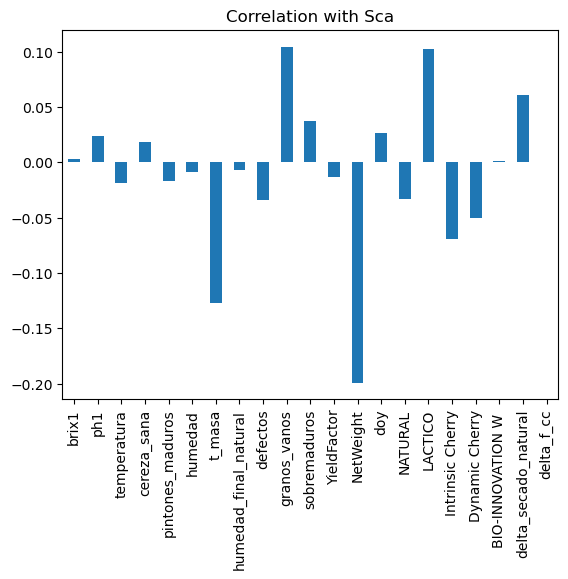

In [109]:
#plt.matshow(nm_df.corr()["Sca"])
#plt.show()
cor_df = df_sliced.corr()["Sca"]
cor_df = cor_df.drop("Sca")
cor_df.plot(kind = "bar", title = "Correlation with Sca")

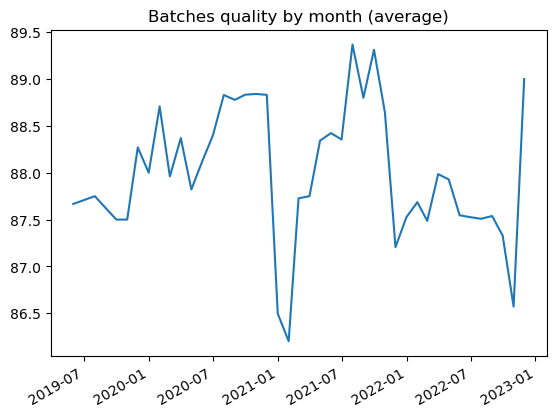

In [110]:
#cols = dt_df[["18", "19", "51", "52"]]
#dt_df[["18", "19", "51", "52"]] = dt_df[["18", "19", "51", "52"]].apply(pd.to_datetime, errors='coerce')
#dt_df[["18", "19", "51", "52"]]
#dt_df
#cols
#dt_df[["18", "19", "51", "52"]]= dt_df[["18", "19", "51", "52"]].apply(lambda t: t.tz_localize(None))
#dt_df[["18", "19", "51", "52"]] = pd.to_datetime(dt_df[["18", "19", "51", "52"]], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
subset = dt_df.loc[:, ["18", 'Sca']]
subset["Sca"].replace(0, np.nan, inplace=True)
#subset["28"].fillna(0, inplace=True)
subset = subset[subset["Sca"].notna()]
subset = subset[subset["18"].notna()]
subset['18'] =  pd.to_datetime(subset['18'], utc=True)
subset = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
subset.set_index('18', inplace=True)
g = subset.groupby(pd.Grouper(freq='M'))["Sca"].mean().reset_index()
g = g[g["Sca"].notna()]


x = g["18"].values.reshape(-1, 1)# plot
y = g["Sca"].values.reshape(-1, 1)
plt.plot(x,y)
plt.title('Batches quality by month (average)')
# beautify the x-labels
plt.gcf().autofmt_xdate()

plt.show()

Now, every SCA outlier value batch is deleted from the dataset. Finally, the batches area classified as 0 for batches with higher SCA values than 87.0 and 1 otherwise and this is the columns target of the classification

In [111]:
toFill_df = df_sliced#.drop(['22', '25', '26', '28', '29', '38', '39', '40', '41', '42', '65', '66','67'], axis=1)

col_map = {toFill_df.columns.get_loc(col):col for col in toFill_df.columns} # {0: "col1", 1: "col2"}
median_values = pd.Series(np.nanmedian(toFill_df, axis=0)).rename(col_map)
filled_df = toFill_df.fillna(median_values)
filled_df = filled_df[(np.abs(stats.zscore(filled_df["Sca"])) < 2)]

In [112]:
def border_class(row):
    if row['Sca'] > 87 :
        return 0
    else:
        return 1

In [113]:
filled_df['border'] = filled_df.apply (lambda row: border_class(row), axis=1)
X = filled_df.drop(['border','Sca'], axis = 1)
y = filled_df[['border']]

75% of the dataset is used for the model training and 25% for testing it 

In [114]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.25)

In [115]:
# first, initialize the classificators
#tree= DecisionTreeClassifier(random_state=24) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=24)
#knn= KNeighborsClassifier()
#svm= SVC(random_state=24)
#xboost= XGBClassifier(random_state=24)

# now, create a list with the objects 
models=[forest] #[tree, forest, knn, svm, xboost]

for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    #cldf = clf_report.transpose()
    #clf_report
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

C:\Users\gabri\AppData\Local\Temp\ipykernel_23604\4217068214.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train) # fit the model


The accuracy of model RandomForestClassifier is 0.83
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       347
           1       0.83      0.68      0.75       200

    accuracy                           0.83       547
   macro avg       0.83      0.80      0.81       547
weighted avg       0.83      0.83      0.83       547





The results are in average 80% accurate, but with a little more recall for the GOOD batcehs. That means that it had quite good performance, but it was not able to get all the BAD batches right. I believe that having more batches with low grades will improve the model, once there is an imbalance in favor of good bathces count in the test dataset in almost 1/2 proportion. 

In [116]:
importances= forest.feature_importances_
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()

feature_names = [f"{i}" for i in X.columns]
# #features_names = ['input1', 'input2']
# #svm = svm.SVC(kernel='linear')
# #svm.fit(X, Y)
#f_importances(svm.coef_, features_names)

It is possible to see that the most important variables in the model training were NetWeight, delta_f_cc which is the delta time of Fermentacion Cereza and the date of year that the batch was created. The variety and the process showed themselves as not relevant to the quality modeling

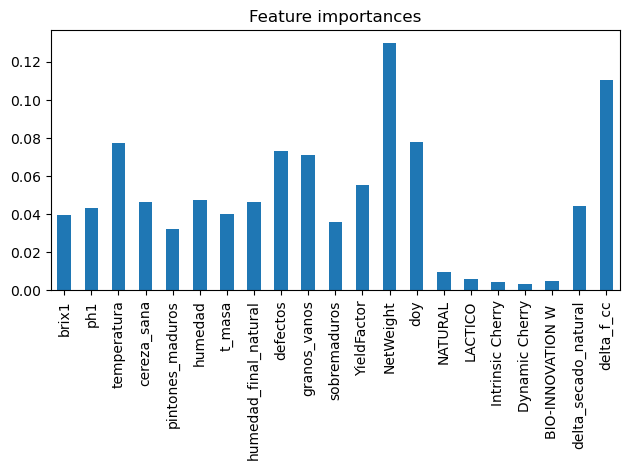

In [117]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Finally, observing the intial exploratory analysis I think that two very important variables that are poorly collected and showed strong correlation to the SCA value are 'rechazo_por_flote' and 'rechazo_cafe_seco', once its directd related to bad quality of the batch. If there is consistent data on this characteristics of the batch, the model could be improved.

It is also notable the lack of data concerning all the variables of 'despulpado' and 'correteo_y_lavado'. I tried to split the dataset by the presence of one of this methods data, but still it is not consistent. The deltas of those data can be relevant and once there is less missing values on this column the model will have more input to work with.

Moreover, looking at the most significant varuable (delta_f_cc), it is inevitable to ellect the variable delta_f_cb, which is the delta of Fermentacion Baba, as a possible relevant one that could not be used for this purpose right now. Focus on get more data for this vairable will certainly help

## Apply Prediction

In [ ]:
pred_df = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="Batch Field Descrip")

In [ ]:
filled_df.columns

In [ ]:
corr = ['brix1', 'ph1', 'temperatura', 'cereza_sana', 'n_bultos', 'kg_amuestra',
       'pintones_maduros', 'humedad', 't_masa', 'humedad_final_natural',
       'defectos', 'granos_vanos', 'sobremaduros', 'YieldFactor',
       'NetWeight',
       'delta_secado_natural', 'delta_f_cc']

In [ ]:
for col in corr:
    subset = filled_df.loc[:, [col, 'Sca']]
    df_filtered = subset[(np.abs(stats.zscore(subset)) < 1).all(axis=1)]
    
    x = df_filtered[col].values.reshape(-1, 1)
    y = df_filtered["Sca"].values.reshape(-1, 1)

    #subset
    #regr = linear_model.LinearRegression()
    #regr.fit(x, y)
    X = sm.add_constant(x)
    est = sm.OLS(y, X)
    est2 = est.fit()
    #print(est2.summary())

    # plot it as in the example at http://scikit-learn.org/
    plt.title('CORRELATION ' + col.upper())
    plt.scatter(x, y,  color='red')
    plt.plot(x, est2.predict(X), color='blue', linewidth=6)
    #plt.xticks(range(min(x), max(x)+1))
    #plt.yticks(range(int(min(y)), int(max(y))+1, 5))
    plt.show()
    print(est2.summary())

It is notable that it is not possible to establish a linear correlation between any of the variables and the SCA value. That makes it quite clear that stablishing a threshold or minimum value to any of the variables in order to achieve a given SCA value will not make any sense

In [ ]:
category_df = fdf.loc[:, ['Process','Program','Proyect', 'Sca']]
category_df = category_df[category_df.Sca != 0]
category_df = category_df[(np.abs(stats.zscore(category_df['Sca'])) < 3)]

In [ ]:
proyect_col = category_df['Proyect'].unique()
program_col = list(category_df['Program'].unique())
program_col.remove('REGIONAL SELECTION')

## Proyect X SCA

In [ ]:
for item in proyect_col:
    subset = category_df[category_df.Proyect == item]
    #subset["28"].fillna(0, inplace=True)
    #subset = subset[subset[item].notna()]
    #tx_filtered = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
    bp = sns.catplot(data=subset, y='Process', x="Sca", kind="box", orient ="h", height=5,aspect=2).fig.suptitle(item + ' x SCA', y = 1.05)

## Program x SCA

In [ ]:
for item in program_col:
    subset = category_df[category_df.Program == item]
    #subset["28"].fillna(0, inplace=True)
    #subset = subset[subset[item].notna()]
    #tx_filtered = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
    bp = sns.catplot(data=subset, y='Process', x="Sca", kind="box", orient ="h", height=5,aspect=2)\
    .fig.suptitle(item + ' x SCA', y=1.05)

In [ ]:
cupping_df = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="cupping")
cupping_df = cupping_df.astype(str)
cupping_df = cupping_df.applymap(remove_acento)
cupping_df['value'] = pd.to_numeric(cupping_df['value'], errors='coerce')
cupping_df['batchid'] = pd.to_numeric(cupping_df['batchid'], errors='coerce')
pivot_cupping = pd.pivot_table(cupping_df, columns = "name", index ="batchid", values = "value", aggfunc=np.mean)
pivot_cupping.index = pivot_cupping.index.astype(int)
df_target = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="Batchs")
df_target = df_target.rename({'Batchid': 'batchid'}, axis=1)  # new method
df_target.set_index('batchid', inplace=True)
df_target.index = df_target.index.astype(int)

In [ ]:
fdf_cupping = pd.merge(pivot_cupping, df_target, left_index=True, right_index=True)

In [ ]:
fdf_cupping = fdf_cupping[['acidez', 'balance', 'cuerpo', 'dulzura', 'fragancia', 'global',
       'post gusto', 'sabor', 'taza limpia', 'uniformidad', 'Proyect',
       'Program', 'Process']]
cup = ['acidez', 'balance', 'cuerpo', 'dulzura', 'fragancia', 'global',
       'post gusto', 'sabor', 'taza limpia', 'uniformidad']

## Cupping x Process

In [ ]:
for item in cup :
    subset = fdf_cupping[ fdf_cupping[item]!=0]
#     subset = subset[['acidez', 'balance', 'cuerpo', 'dulzura', 'fragancia', 'global',
#        'post gusto', 'sabor', 'taza limpia', 'uniformidad']]
    #subset["28"].fillna(0, inplace=True)
    #subset = subset[subset[item].notna()]
    #tx_filtered = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
    bp = sns.catplot(data=subset, y='Process', x=item, kind="box")\
    .fig.suptitle(item + ' x Process', y=1.05)

## Cuppping x Program

In [ ]:
for item in cup :
    subset = fdf_cupping[fdf_cupping[item]!=0]
    subset = subset[subset['Program']!='REGIONAL SELECTION']
#     subset = subset[['acidez', 'balance', 'cuerpo', 'dulzura', 'fragancia', 'global',
#        'post gusto', 'sabor', 'taza limpia', 'uniformidad']]
    #subset["28"].fillna(0, inplace=True)
    #subset = subset[subset[item].notna()]
    #tx_filtered = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
    bp = sns.catplot(data=subset, y='Program', x=item, kind="box")\
    .fig.suptitle(item + ' x Program', y=1.05)

In [ ]:
#!jupyter nbconvert --to html coffee_report.ipynb --no-input --execute